In [9]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d, RegularGridInterpolator
from astropy.cosmology import Planck13 as cosmo

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sea
# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon, F_lam_per_M
import fsps
from spec_id import Scale_model
from spec_tools import Oldest_galaxy, Photometry
from spec_stats import Highest_density_region

import dynesty
from dynesty import plotting as dyplot
from glob import glob

from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

from prospect.models.transforms import logsfr_ratios_to_masses
from multiprocessing import Pool
from scipy import stats

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

In [3]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)

Gs = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.0, decontam = True) 

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [14]:
def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

(3.0, 4.6020599913279625)

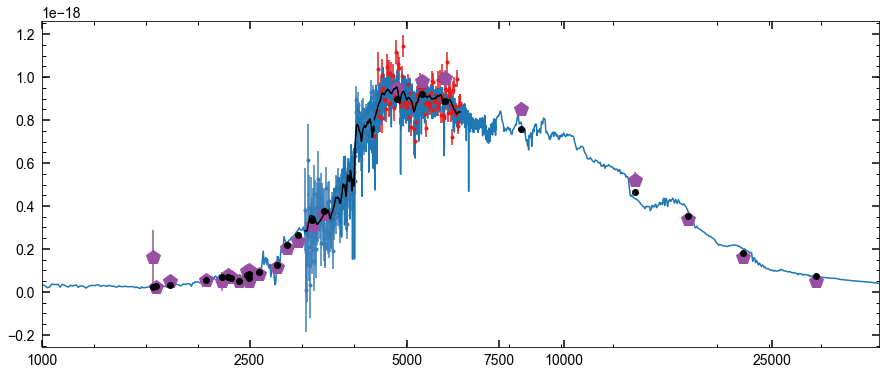

In [33]:
# Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux, specz)

# PC= Full_scale(Gs, Pmfl)

# Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl,Gs.Ber,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl,Gs.Rer,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx,Gs.Perr,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl, 'k', zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl, 'ko', zorder=5)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.plot(np.log10(wave * (1)),flux  / (10**bfm*1E9 * conv))
plt.xlim(np.log10(1000), np.log10(40000))

In [56]:
(sum(((Gs.Bfl - Gs.Bmfl) / Gs.Ber)**2) + sum(((Gs.Rfl - Gs.Rmfl) / Gs.Rer)**2) + sum(((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2)) * (-0.5)

-235.96446439759274

In [5]:
###############
###set prior###
###############

def convert_sfh(agebins, mformed, epsilon=1e-4, maxage=None):
    #### create time vector
    agebins_yrs = 10**agebins.T
    dt = agebins_yrs[1, :] - agebins_yrs[0, :]
    bin_edges = np.unique(agebins_yrs)
    if maxage is None:
        maxage = agebins_yrs.max()  # can replace maxage with something else, e.g. tuniv
    t = np.concatenate((bin_edges * (1.-epsilon), bin_edges * (1+epsilon)))
    t.sort()
    t = t[1:-1] # remove older than oldest bin, younger than youngest bin
    fsps_time = maxage - t

    #### calculate SFR at each t
    sfr = mformed / dt
    sfrout = np.zeros_like(t)
    sfrout[::2] = sfr
    sfrout[1::2] = sfr  # * (1+epsilon)

    return (fsps_time / 1e9)[::-1], sfrout[::-1], maxage / 1e9

specz = 1.25257

lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

agelim = Oldest_galaxy(specz)

def prior(u):
    m = (0.03 * u[0] + 0.001) / 0.019
    
    a = (agelim - 1)* u[1] + 1
    
    tsamp = np.array([u[2],u[3],u[4],u[5],u[6],u[7],u[8],u[9], u[10], u[11]])

    taus = stats.t.ppf( q = tsamp, loc = 0, scale = 0.3, df =2.)

    m1, m2, m3, m4, m5, m6, m7, m8, m9, m10 = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = agebins) * 1E9
    
    z = stats.norm.ppf(u[12],loc = specz, scale = 0.003)
    
    d = u[13]
        
    return [m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d]

In [6]:
def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_scale(spec, Pmfl):
    return Scale_model(spec.Pflx, spec.Perr, Pmfl)

def Gather_grism_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.Bfl)
        errs.append(spec.Ber)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.Rfl)
        errs.append(spec.Rer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs)):
        Gmfl.append(forward_model_all_beams(beams[i], trans[i], wvs[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs)):
        scale = Scale_model(flxs[i], errs[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs[i] / scale) - Gmfl[i]) / (errs[i] / scale))**2))
    
    Pchi = np.sum((((spec.Pflx - Pmfl) / spec.Perr)**2))
    
    return Gchi, Pchi


def tab_L(X):
    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, z, d = X
    
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(agebins, [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10])

    sp.set_tabular_sfh(time,sfr)    
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)

    Gmfl, Pmfl = Full_forward_model(Gs, wave, flux, z)
          
    PC= Full_scale(Gs, Pmfl)

    Gchi, Pchi = Full_fit(Gs, PC*Gmfl, PC*Pmfl)
                  
    return -0.5 * (Gchi + Pchi)

In [13]:
wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

In [16]:
d_tsampler = dynesty.DynamicNestedSampler(tab_L, prior, nlive_init=2000, ndim = 14, sample = 'rwalk', bound = 'multi',
                                  queue_size = 8, pool = Pool(processes=8))  


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampling.py:200: UserWarning: Random number generation appears to be extremely inefficient. Bounding distributions might be sub-optimal.
  warnings.warn("Random number generation appears to be "


In [ ]:
d_tsampler.run_nested(wt_kwargs={'pfrac': 1.0}, dlogz_init=0.01, print_progress=True)

dres = d_tsampler.results

iter: 3754 | batch: 0 | bound: 127 | nc: 25 | ncall: 67720 | eff(%):  5.503 | loglstar:   -inf < -429.237 <    inf | logz: -441.330 +/-  0.149 | dlogz: 204.775 >  0.010            

In [70]:
# save results
dres = dsampler.results
# zres = zsampler.results
 

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/sampler.py:220: RuntimeWarning: invalid value encountered in sqrt
  ('logzerr', np.sqrt(np.array(self.saved_logzvar))),


In [63]:
t,pt = Get_posterior(zres.samples[:,3 ],zres.logwt,zres.logz)
t[pt == max(pt)][0]

NameError: name 'zres' is not defined

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a836d05c0>,
       dtype=object))

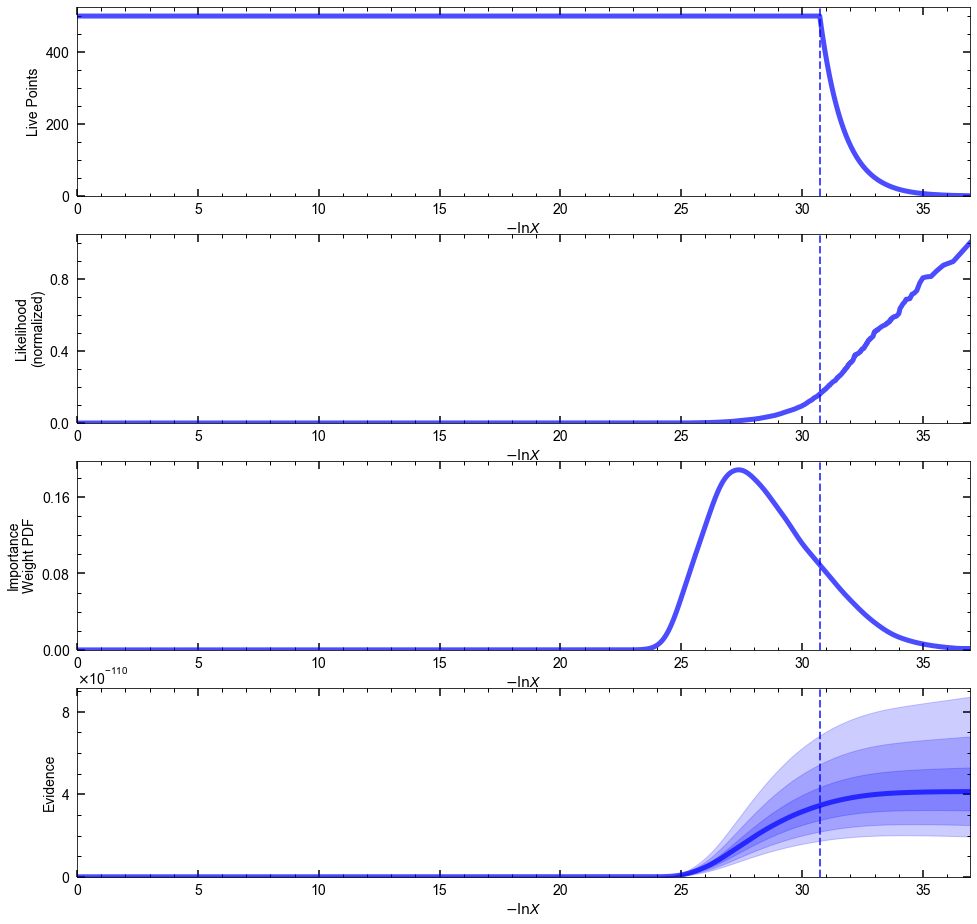

In [71]:
dyplot.runplot(dres)

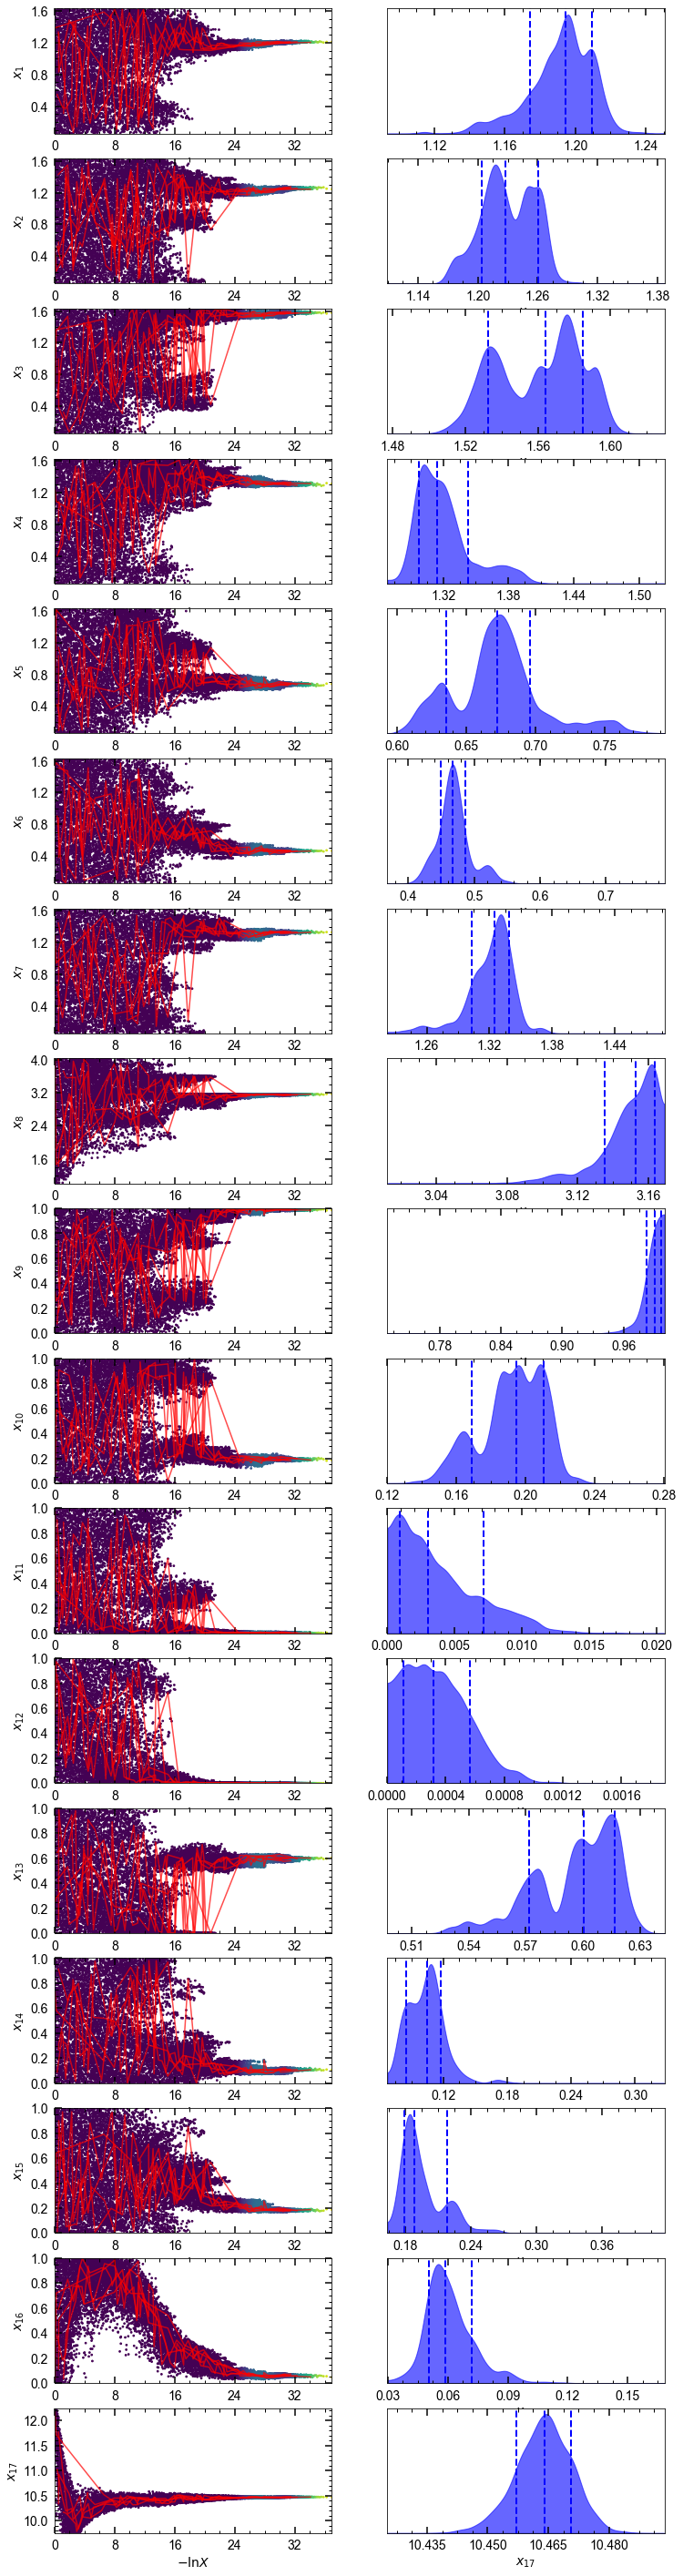

In [72]:
fig, axes = dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

In [34]:
# np.save('../data/out_dict/GSD_41520_assembly_3', dres)

(<Figure size 547.2x547.2 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a73adb080>,
       dtype=object))

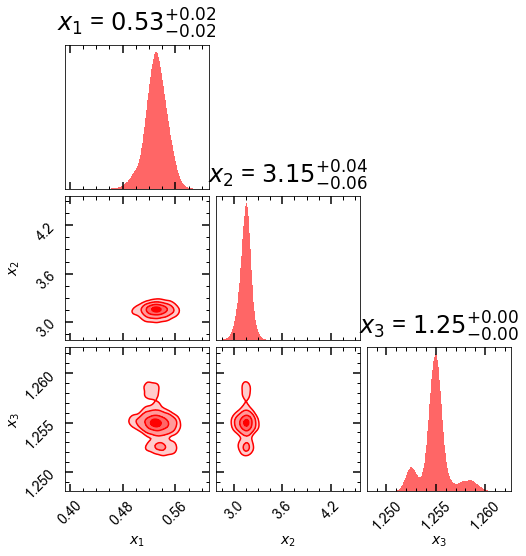

In [27]:
dyplot.cornerplot(dres2, color='red', truths=None, truth_color='black',#labels = ['Z','t','$\\tau$','z','Av'],
                           show_titles=True, title_kwargs={'y': 1.05}, 
                           quantiles=None, max_n_ticks=3, )

In [13]:
LBT

array([1.56, 2.8 , 3.73, 4.35, 4.67])

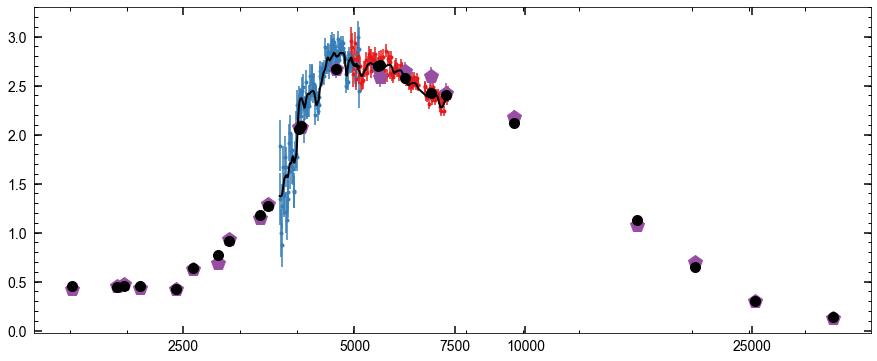

In [25]:
#  array([0.57029166, 3.07055345, 0.35029257, 1.24904928, 0.11330445]))

sp.params['logzsol'] = np.log10(0.58)
sp.params['tau'] = 0.31
sp.params['dust2'] = 0.11
    
wave,flux = sp.get_spectrum(tage = 2.73,peraa = True)
    
Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.SBfl, Gs.SBer, PC*Bmfl)
Rscale = Scale_model(Gs.SRfl, Gs.SRer, PC*Rmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.SBfl*1E18,Gs.SBer*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.SRfl*1E18,Gs.SRer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.SPflx*1E18,Gs.SPerr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)

In [31]:
sp.params['compute_light_ages'] = True

wave,flux = sp.get_spectrum(tage = 4.2)

print(interp1d(wave,flux)(4770))
sp.params['compute_light_ages'] = False


2.214131598293001


In [17]:
np.where(dres.logl == np.max(dres.logl)),np.max(dres.logl),dres.samples[23212]

((array([23212]),),
 -208.85208150766476,
 array([2.70641723e-01, 6.67155957e-01, 6.87389477e-01, 8.32059545e-01,
        1.25340266e+00, 1.41717829e+00, 4.56506094e+00, 5.74995179e-01,
        5.39438086e-01, 5.32047776e-01, 2.68029355e-02, 4.10062829e-03,
        4.37931106e-04, 1.25361941e+00, 1.04803298e-01]))

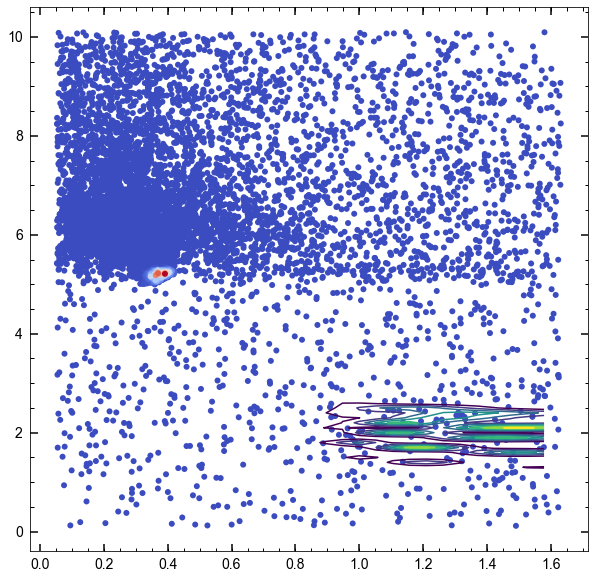

In [13]:
P = np.load('../../Quiescent_analysis/chidat/n21156_dtau_tZ_pos_lwa_dust.npy')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
M,A=np.meshgrid(metal/0.019,age)

plt.figure(figsize=(10, 10))
plt.scatter(dres.samples[:, 0], dres.samples[:, 1],
               marker='o', c=np.exp(dres.logl), linewidths=(0.,), cmap='coolwarm')

# plt.scatter(dres.samples[:, 0][IDX[242]], dres.samples[:, 1][IDX[242]],
#                marker='o', c='k')
plt.contour(M,A,P)


In [21]:
sp.params['compute_light_ages'] = True
lwa = np.zeros(len(dres.samples))
for i in range(len(dres.samples)):
    sp.params['logzsol'] = np.log10(dres.samples[i][0])
    sp.params['tau'] = dres.samples[i][2]
    sp.params['dust2'] = dres.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres.samples[i][1])
    
    lwa[i] = interp1d(wave,flux)(4770)


In [40]:
sp.params['compute_light_ages'] = True
lwa2 = np.zeros(len(dres2.samples))
for i in range(len(dres2.samples)):
    sp.params['logzsol'] = np.log10(dres2.samples[i][0])
    sp.params['tau'] = dres2.samples[i][2]
    sp.params['dust2'] = dres2.samples[i][4]  
    wave, flux = sp.get_spectrum(tage = dres2.samples[i][1])
    
    lwa2[i] = interp1d(wave,flux)(4770)

In [38]:
sp.params['logzsol'] = np.log10(1)
sp.params['tau'] = 1
sp.params['dust2'] = 0.1  
wave, flux = sp.get_spectrum(tage = 0.5)
print(interp1d(wave,flux)(4770))

0.0920121117084283


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


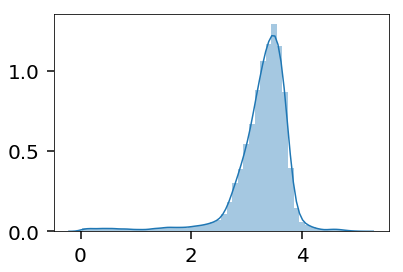

In [139]:
sea.distplot(dres1.samples[:,1])
# sea.distplot(lwa1)
# plt.xlim(0,5)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


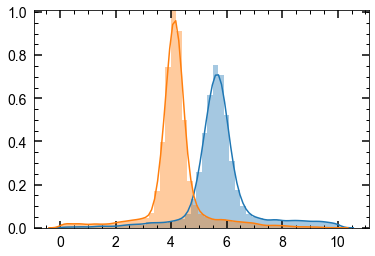

In [22]:
sea.distplot(dres.samples[:,1])
sea.distplot(lwa)

In [43]:
dres1.samples[:,1] = lwa1
dres2.samples[:,1] = lwa2

In [77]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Get_posterior(sample,logwt,logz):
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

[2.92597421e-05]


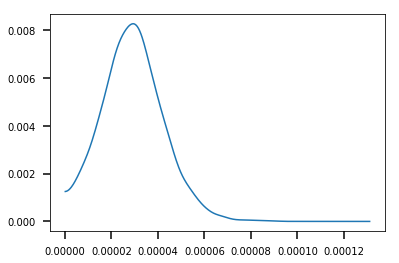

In [99]:
x,PX = Get_posterior(dres2b.samples[:,5], dres2['logwt'], dres2['logz'])

plt.plot(x,PX)
print(x[PX == max(PX)])

In [111]:
in1 = np.loadtxt('/Users/vestrada/alf/atlas_ssp_t03_Zp0.0.abund.krpa.s100').T

In [127]:
sp.params['logzsol'] = np.log10( 1 )
# sp.params['tau'] = 0.1
sp.params['sfh'] = 0

sp.params['dust2'] = 0.0

wave, flux = sp.get_spectrum(tage = 3, peraa = True)

(3.5, 4.5)

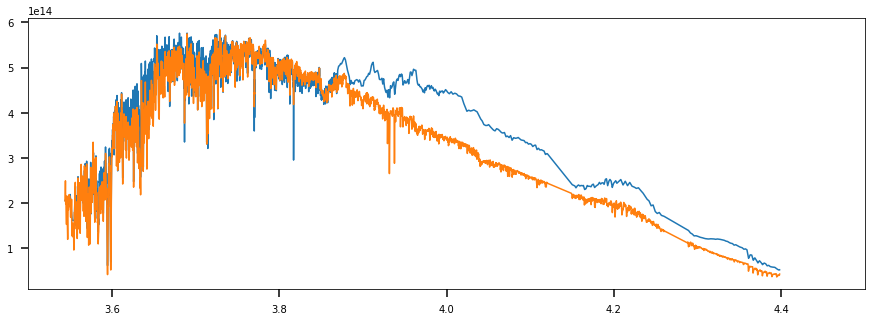

In [132]:
iflux = interp1d(wave,flux)(in1[0])
plt.figure(figsize=[15,5])
# plt.plot(np.log10(wave),flux*1.5E19)
plt.plot(np.log10(in1[0]), iflux*.9E19)
plt.plot(np.log10(in1[0]), (3E18 / in1[0]**2)*in1[1])



plt.xlim(3.5,4.5)

# review all completed cycles

In [31]:
dres1 = np.load('../data/out_dict/GND_21156_testfit_tmp_LF.npy').item()
dres2 = np.load('../data/out_dict/GND_21156_testfit_tmp_EF.npy').item()
dres3 = np.load('../data/out_dict/GND_21156_testfit_tmp_ND.npy').item()
dres4 = np.load('../data/out_dict/GND_21156_testfit_tmp_LF_tab.npy').item()
dres5 = np.load('../data/out_dict/GND_21156_testfit_tmp_EF_tab.npy').item()

dres6 = np.load('../data/out_dict/GND_21156_testfit_LF.npy').item()
dres7 = np.load('../data/out_dict/GND_21156_testfit_EF.npy').item()
dres8 = np.load('../data/out_dict/GND_21156_testfit_ND.npy').item()
dres9 = np.load('../data/out_dict/GND_21156_testfit_LF_tab.npy').item()

dres10 = np.load('../data/out_dict/GND_21156_testfit_EF_tab.npy').item()

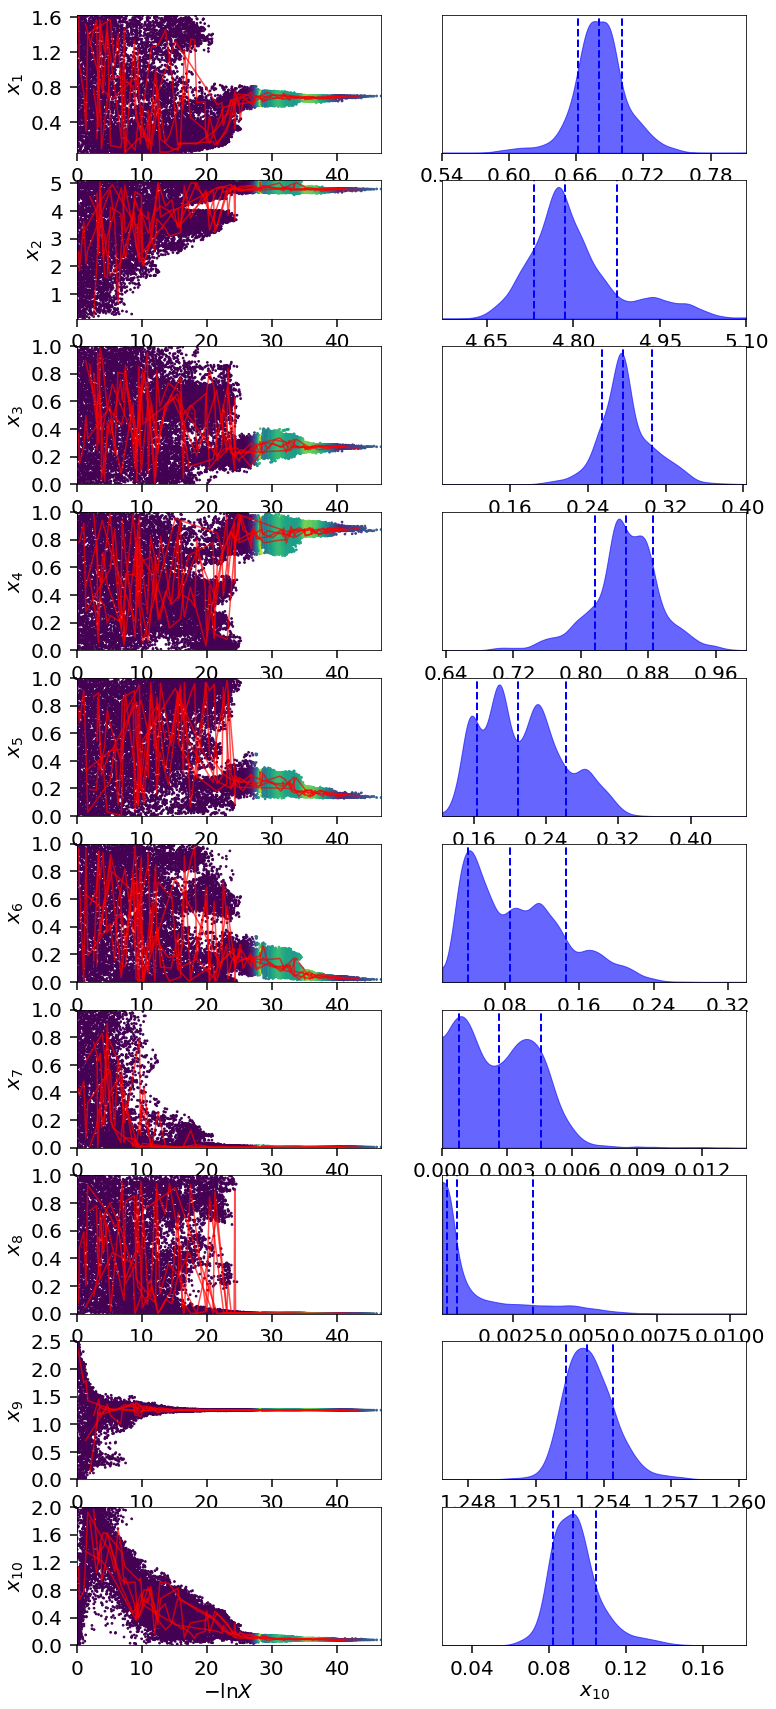

In [34]:
fig, axes = dyplot.traceplot(dres9, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

(<Figure size 1605.6x1605.6 with 100 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a88c549e8>,
       dtype=object))

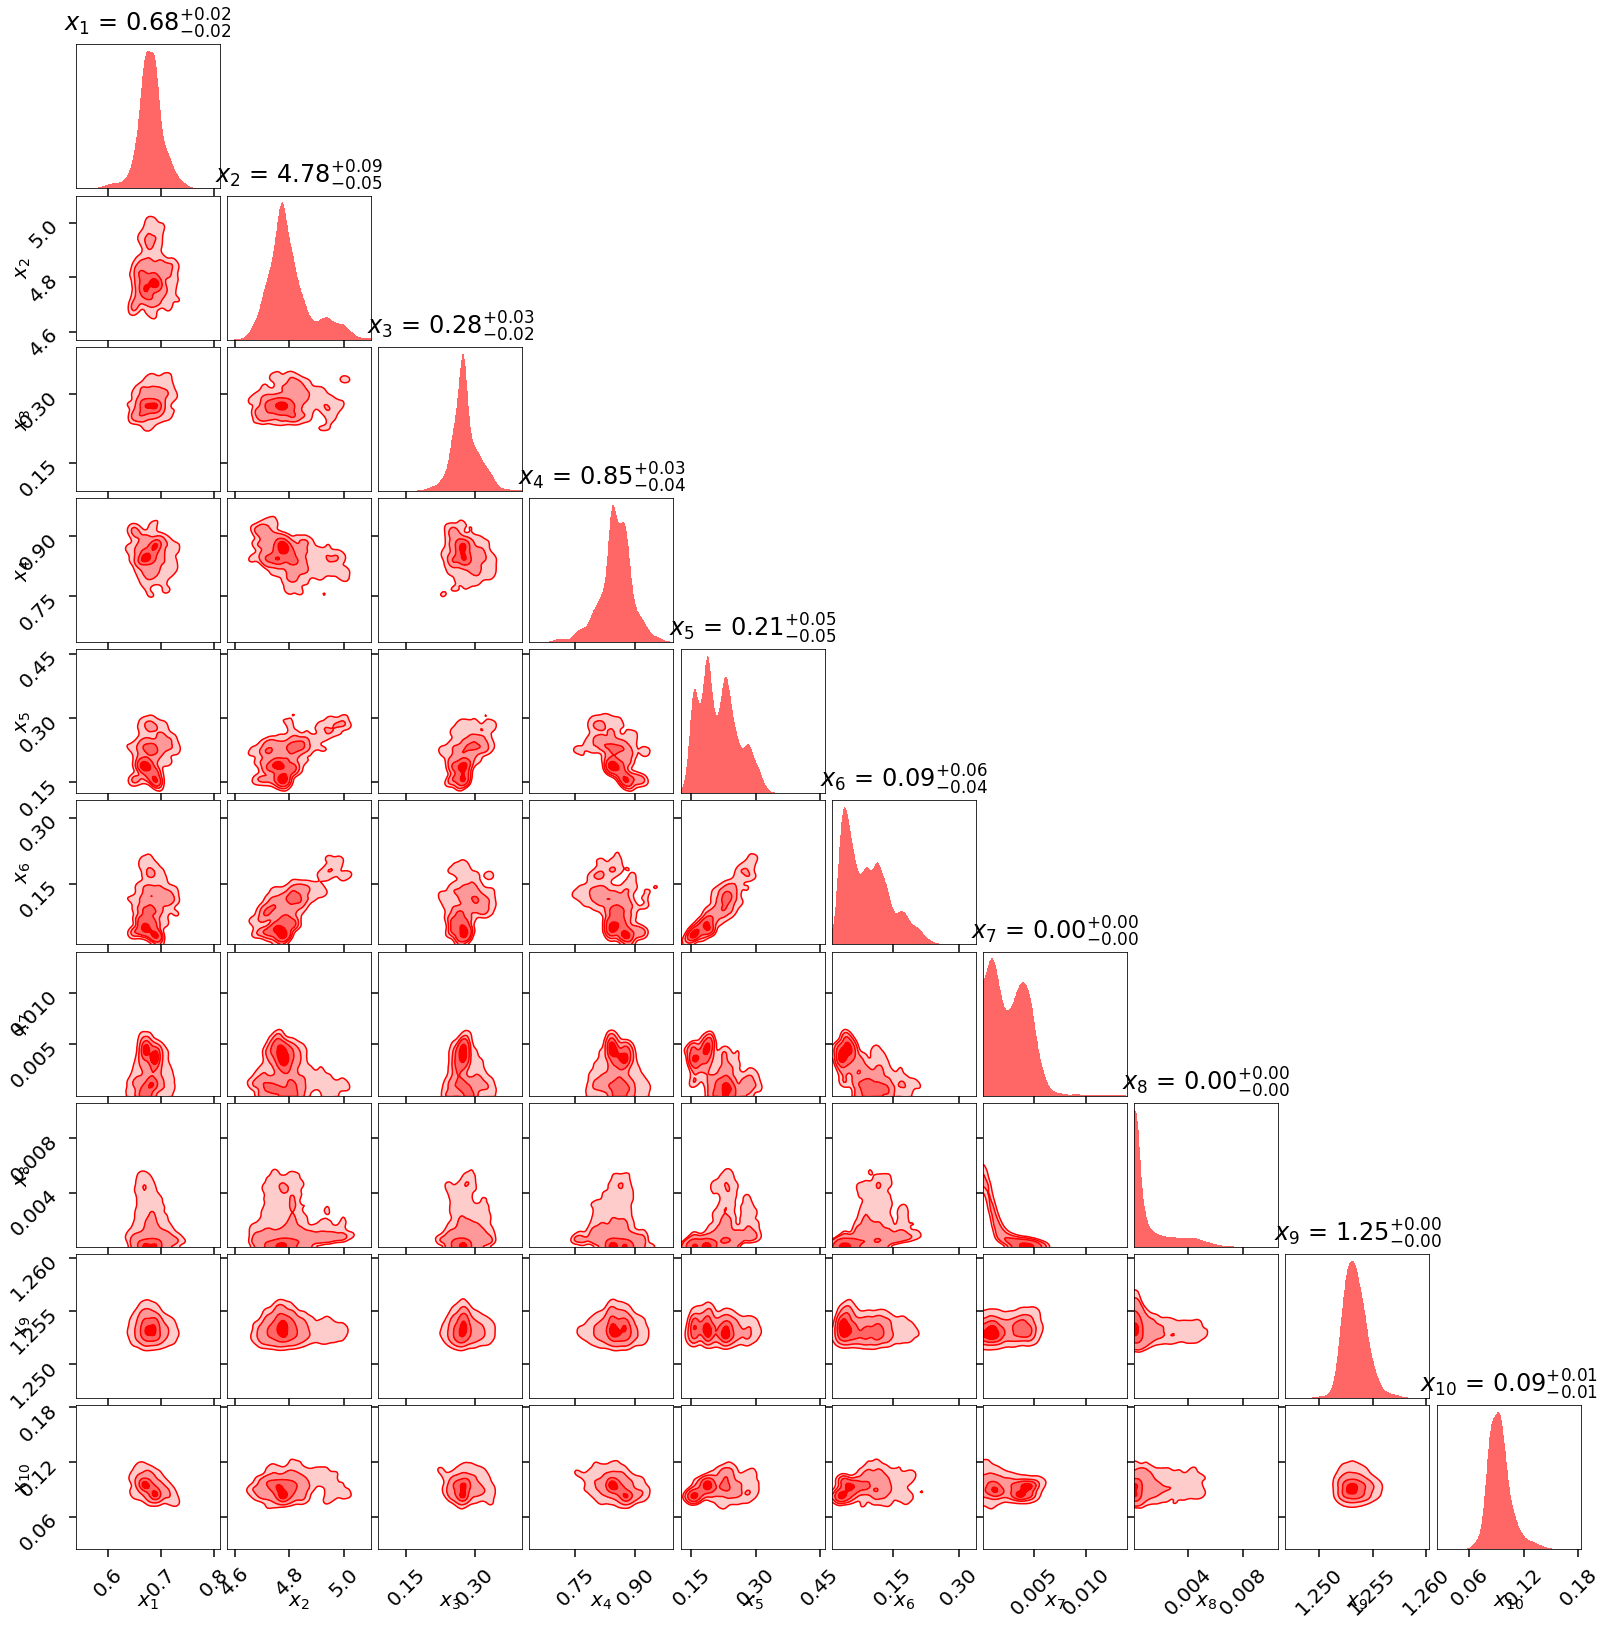

In [35]:
dyplot.cornerplot(dres9, color='red', truths=None, truth_color='black',#labels = ['Z','t','$\\tau$','z','Av'],
                           show_titles=True, title_kwargs={'y': 1.05}, 
                           quantiles=None, max_n_ticks=3, )

<ErrorbarContainer object of 3 artists>

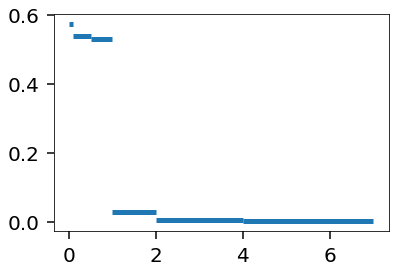

In [24]:
plt.errorbar(np.array([0.1, 0.5, 1, 2, 4, 7]),np.array([0.575, 0.539, 0.532, 0.027, 0.004,0.0004]),xerr = [[0.1,0.4,0.5,1,2,3],[0,0,0,0,0,0]],fmt = 'o',ms=0,linewidth=5)

<ErrorbarContainer object of 3 artists>

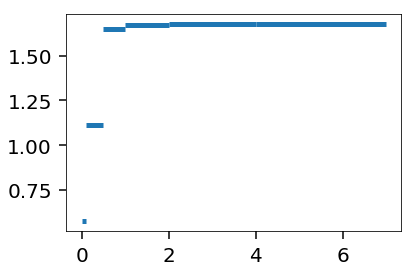

In [26]:
plt.errorbar(np.array([0.1, 0.5, 1, 2, 4, 7]),
             np.array([0.575, 0.539 + 0.575, 0.532 + 0.539 + 0.575, 0.027 + 0.532 + 0.539 + 0.575, 0.004 + 0.027 + 0.532 + 0.539 + 0.575,0.0004 + 0.004 + 0.027 + 0.532 + 0.539 + 0.575]),
             xerr = [[0.1,0.4,0.5,1,2,3],[0,0,0,0,0,0]],fmt = 'o',ms=0,linewidth=5)

In [33]:
np.where(dres1.logl == np.max(dres1.logl)),np.max(dres1.logl),dres1.samples[26460]

((array([26460]),),
 -93.11404487774317,
 array([0.32468948, 4.83708409, 0.49859328, 1.25364188, 0.20821861]))

In [35]:
np.where(dres6.logl == np.max(dres6.logl)),np.max(dres6.logl),dres6.samples[28730]

((array([28730]),),
 -212.87524121550115,
 array([0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945]))

In [41]:
np.where(dres7.logl == np.max(dres7.logl)),np.max(dres7.logl),dres7.samples[28603]

((array([28603]),),
 -211.80592481091657,
 array([0.60347418, 5.68625517, 0.61053635, 1.25292823, 0.07791594]))

In [38]:
np.where(dres9.logl == np.max(dres9.logl)),np.max(dres9.logl),dres9.samples[32110]

((array([32110]),),
 -212.07630523308626,
 array([7.01082532e-01, 4.78812212e+00, 2.72526675e-01, 8.73381849e-01,
        1.34358664e-01, 1.78666045e-02, 5.39302455e-03, 1.37082047e-04,
        1.25280924e+00, 7.94224483e-02]))

In [69]:
np.where(dres10.logl == np.max(dres10.logl)),np.max(dres10.logl),dres10.samples[27588]

((array([27588]),),
 -205.36900949085887,
 array([ 0.64668916, 10.09676873,  0.30959742,  0.9492099 ,  0.88531001,
         0.6769806 ,  0.81779508,  0.14122372,  0.04172833,  1.25335991,
         0.10707565]))

In [13]:
np.where(dres.logl == np.max(dres.logl)),np.max(dres.logl),dres.samples[35673]

((array([35673]),),
 -199.3968913053439,
 array([5.95557527e-01, 9.66809769e-01, 1.49535237e+00, 2.32900348e-01,
        7.15368984e-02, 1.49897341e+00, 4.97765566e+00, 3.55015018e-01,
        1.80599659e-01, 8.20441816e-01, 4.34977115e-01, 1.00547157e-03,
        4.34187149e-03, 1.25319095e+00, 2.40421865e-01]))

432.4787478296225


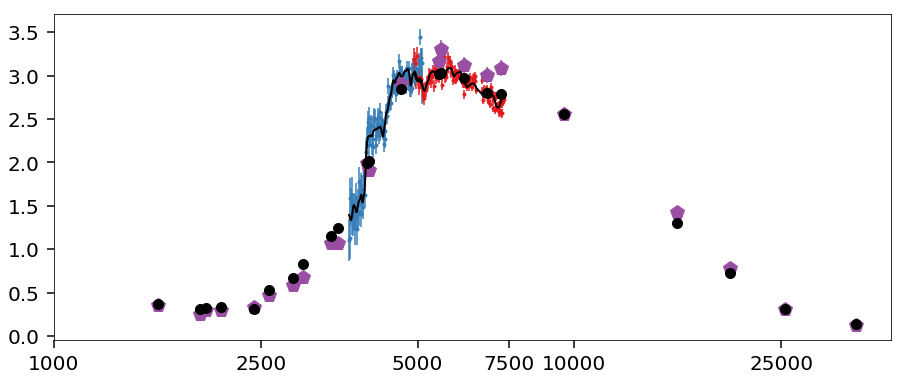

In [64]:
Gs.Sim_all(0.012/0.019, 4.93, 0.545, 1.2529, 0.06)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

442.4641927282162


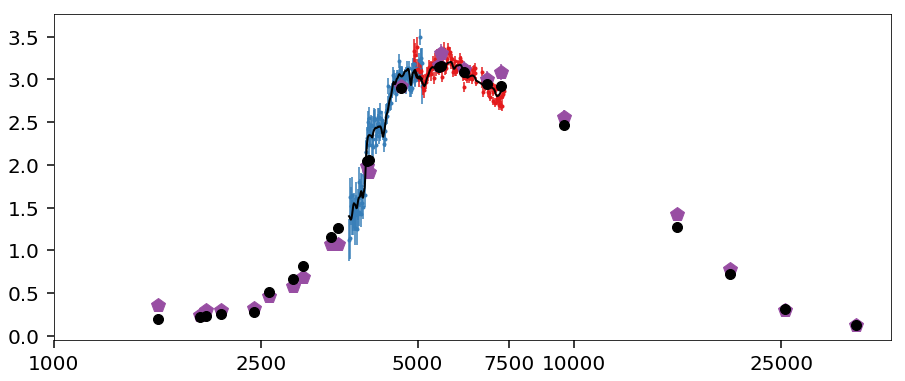

In [65]:
Gs.Sim_all(0.32468948, 4.83708409, 0.49859328, 1.25364188, 0.20821861)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

416.6229833301954


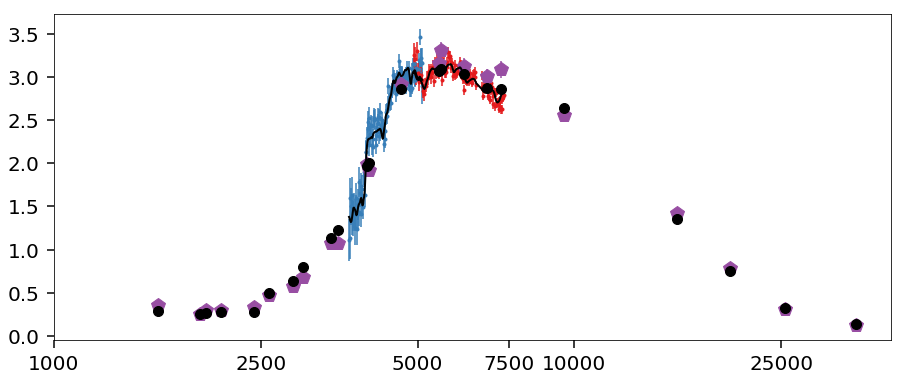

In [66]:
Gs.Sim_all(0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

416.9092782718844


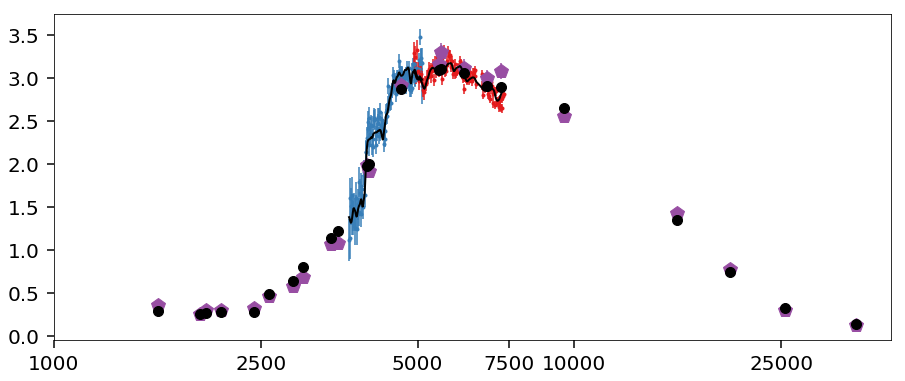

In [67]:
Gs.Sim_all(0.60347418, 5.68625517, 0.61053635, 1.25292823, 0.07791594)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18, Gs.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18, Gs.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), Gs.Bmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), Gs.Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), Gs.Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

Bchi = np.sum(((((Gs.Bfl) - Gs.Bmfl) / (Gs.Ber))**2))
Rchi = np.sum(((((Gs.Rfl) - Gs.Rmfl) / (Gs.Rer))**2))
Pchi = np.sum((((Gs.Pflx - Gs.Pmfl) / Gs.Perr)**2))
print(Bchi + Rchi + Pchi)

In [39]:
0.2725, 0.8734, 0.1344, 0.0179, 0.0054, 0.0001,


sp.params['sfh'] = 3
sp.params['logzsol'] = np.log10( 0.70108)
sp.params['dust2'] = 0.079
sp.set_tabular_sfh(np.array([0.1, 0.5, 1, 2, 4, 6]),np.array([0.2725, 0.8734, 0.1344, 0.0179, 0.0054, 0.0001]))

wave,flux = sp.get_spectrum(tage = 4.788,peraa=True)
sp.params['sfh'] = 4

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


347.37621271091797


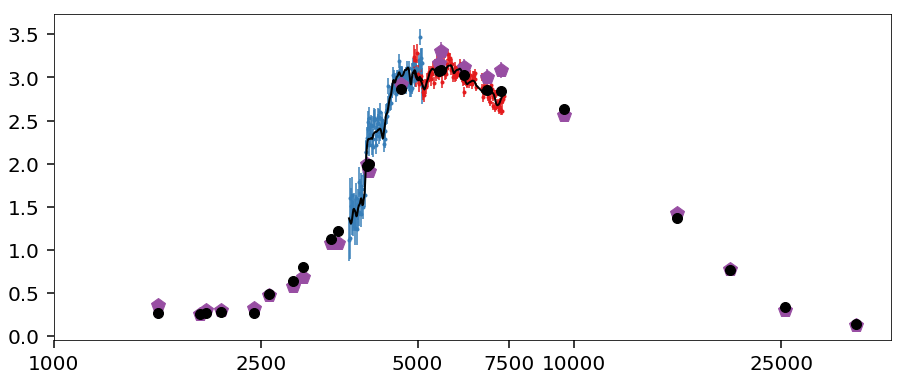

In [47]:
Gs = Gen_spec('GND', 21156, 1.25378,
               g102_lims=[8300, 11500], g141_lims=[11100, 16500],mdl_err = False, instr_err = False,
            phot_errterm = 0.03, decontam = True) 

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25280924)

PC= Scale_model(Gs.Pflx,Gs.Perr,Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

Bchi= np.sum(( (Gs.Bfl / Bscale - PC*Bmfl) / Gs.Ber/ Bscale)**2) 
Rchi= np.sum(( (Gs.Rfl / Rscale - PC*Rmfl) / Gs.Rer/ Rscale)**2) 
Pchi= np.sum(( (Gs.Pflx - PC*Pmfl) / Gs.Perr)**2) 

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
print(Bchi + Rchi + Pchi)

In [16]:
sp.params['sfh'] = 3
sp.params['dust2'] = 0.24
sp.set_tabular_sfh(np.array([0.1, 0.5, 1, 2, 4, 7]),np.array([0.355, 0.18, 0.82, 0.435, 0.001,0.004]),
        Z = np.array([0.5956, 0.96681, 1.495, 0.233, 0.07, 1.498]) * 0.019)

wave,flux = sp.get_spectrum(tage =4.977,peraa=True)
sp.params['sfh'] = 4


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


400.81530599661414


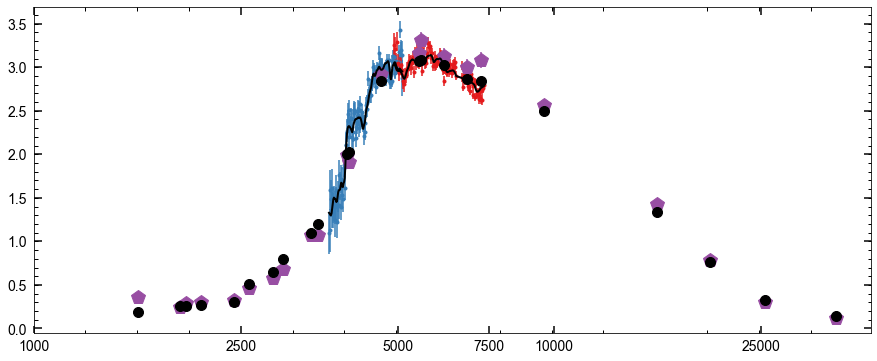

In [17]:
Gs = Gen_spec('GND', 21156, 1.25378,
               g102_lims=[8300, 11500], g141_lims=[11100, 16500],mdl_err = False, instr_err = False,
            phot_errterm = 0.03, decontam = True) 

Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux , 1.25319)

PC= Full_scale(Gs, Pmfl)

Bscale = Scale_model(Gs.Bfl, Gs.Ber, PC*Bmfl)
Rscale = Scale_model(Gs.Rfl, Gs.Rer, PC*Rmfl)

Bchi, Rchi, Pchi = Full_fit(Gs, PC * Bmfl, PC * Rmfl, PC * Pmfl)

plt.figure(figsize = [15,6])
plt.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl*1E18 / Bscale,Gs.Ber*1E18/ Bscale,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl*1E18/ Rscale,Gs.Rer*1E18/ Rscale,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
                                 linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(np.log10(Gs.Bwv_rf), PC*Bmfl*1E18, 'k', linewidth=2,zorder=5)
plt.plot(np.log10(Gs.Rwv_rf), PC*Rmfl*1E18, 'k',linewidth=2, zorder=5)
plt.plot(np.log10(Gs.Pwv_rf), PC*Pmfl*1E18, 'ko', zorder=5,ms=10)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
print(Bchi + Rchi + Pchi)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


([<matplotlib.axis.XTick at 0x1a7bff2cc0>,
 <a list of 6 Text xticklabel objects>)

<Figure size 1080x432 with 0 Axes>

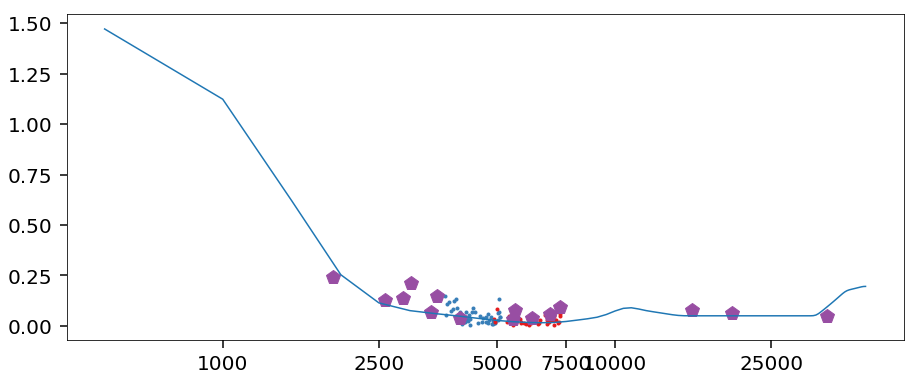

In [98]:
Gs.Sim_all(0.012/0.019, 4.93, 0.545, 1.2529, 0.06)
plt.figure(figsize = [15,6])
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


([<matplotlib.axis.XTick at 0x1a919d2b00>,
 <a list of 6 Text xticklabel objects>)

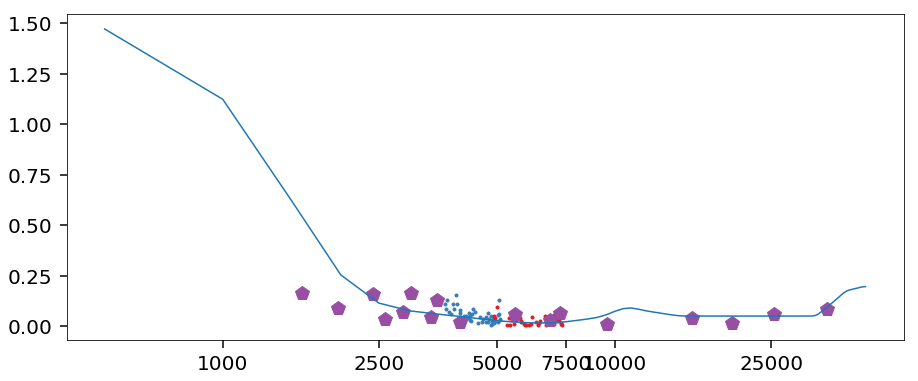

In [49]:
Gs.Sim_all(0.6280001 , 5.09097778, 0.54372305, 1.25261409, 0.08475945)
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


([<matplotlib.axis.XTick at 0x1a912b0438>,
 <a list of 6 Text xticklabel objects>)

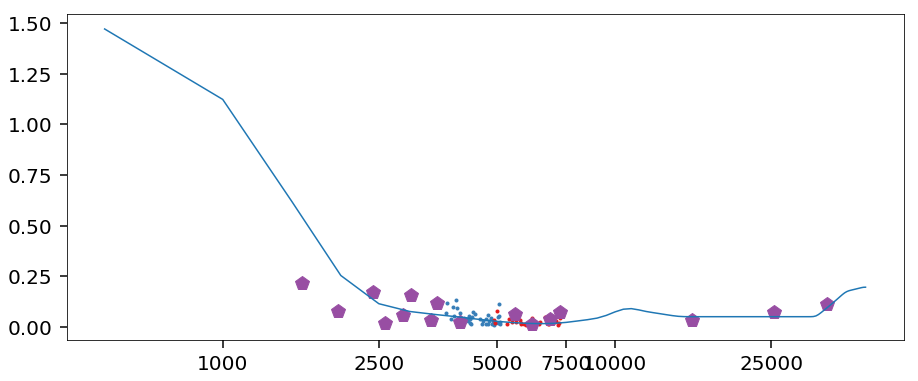

In [48]:
wv,tmp = np.load('../templates/mdl_EF.npy')
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),np.sqrt(((Gs.Bfl/ Bscale - PC*Bmfl) / Gs.Bfl/ Bscale)**2 - (Gs.Ber / Gs.Bfl)**2), 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),np.sqrt(((Gs.Rfl / Rscale- PC*Rmfl) / Gs.Rfl/ Rscale)**2 - (Gs.Rer / Gs.Rfl)**2), 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),np.sqrt(((Gs.Pflx- PC*Pmfl) / Gs.Pflx)**2 - (Gs.Perr / Gs.Pflx)**2),
                'p', markersize=15, color='#984ea3')
plt.plot(np.log10(wv),tmp)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

([<matplotlib.axis.XTick at 0x1a8e753dd8>,
 <a list of 6 Text xticklabel objects>)

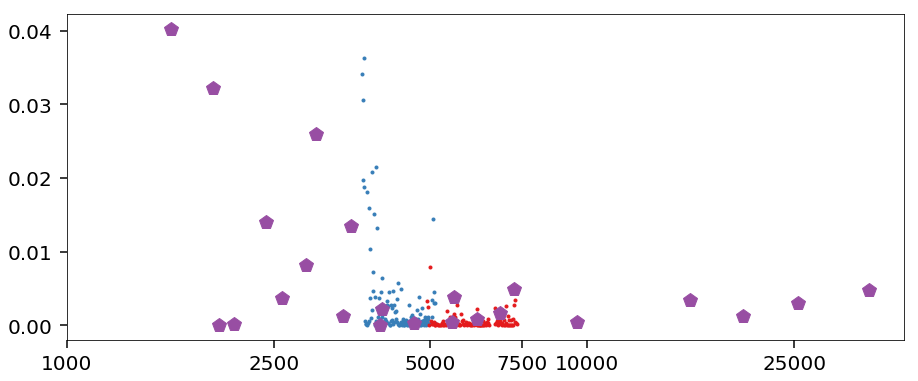

In [95]:
plt.figure(figsize = [15,6])
plt.plot(np.log10(Gs.Bwv_rf),((Gs.Bfl/ Bscale - PC*Bmfl) / Gs.Bfl/ Bscale)**2 , 
                'o', markersize=3, color='#377eb8')
plt.plot(np.log10(Gs.Rwv_rf),((Gs.Rfl / Rscale- PC*Rmfl) / Gs.Rfl/ Rscale)**2 , 
                'o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Gs.Pwv_rf),((Gs.Pflx- PC*Pmfl) / Gs.Pflx)**2 ,
                'p', markersize=15, color='#984ea3')

# plt.plot(np.log10(Gs.Bwv_rf),((Gs.Bfl - Gs.Bmfl) / Gs.Bfl)**2, 
#                 'o', markersize=3, color='k')
# plt.plot(np.log10(Gs.Rwv_rf),((Gs.Rfl - Gs.Rmfl) / Gs.Rfl)**2, 
#                 'o', markersize=3, color='k')
# plt.plot(np.log10(Gs.Pwv_rf),((Gs.Pflx- Gs.Pmfl) / Gs.Pflx)**2,
#                 'p', markersize=15, color='k')

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])

In [ ]:
asdf